In [51]:
import sys
import torch as t
import numpy as np
from matplotlib import pyplot as plt
import json
from itertools import product
sys.path.append('/workspace/Finite-groups/src')
from model import MLP3, InstancedModule
from evals import load_models
from utils import *
from group_data import *
from jaxtyping import Float
from typing import Union
from einops import repeat
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import copy
from itertools import product
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")

In [3]:
path = '/workspace/Finite-groups/src/models/2024_07_25_18_08_00_Z_48_2__twZ_48_'
models, params = load_models(path)

In [4]:
dataset = GroupData(params)

Intersection size: 6912/9216 (0.75)
Added 6912 elements from intersection
Added 0 elements from group 0: Z(48,2)
Added 0 elements from group 1: twZ(48)
Train set size: 6912/9216 (0.75)


In [5]:
@t.no_grad()
def train_loss(
    model: InstancedModule,
    dataset: GroupData,
) -> Float[t.Tensor, 'instance']:
    loader = DataLoader(
        dataset=dataset,
        batch_size=len(dataset),
        shuffle=False,
        drop_last=False
    )
    model.eval()
    loss = 0
    for x, z in loader:
        x = x.to(device)
        z = z.to(device)
        output = model(x)
        loss += get_cross_entropy(output, z)
    return loss / len(loader)

In [6]:
loss = train_loss(models[-1].to(device), dataset)

In [43]:
def sgld_trace(
    model: InstancedModule,
    dataset: GroupData,
    eps: Union[Float[t.Tensor, 'instance'], Float[t.Tensor, '1'], float],
    beta: Union[Float[t.Tensor, 'instance'], Float[t.Tensor, '1'], float],
    gamma: Union[Float[t.Tensor, 'instance'], Float[t.Tensor, '1'], float],
    epochs: int=2000,
    instances: int=1,
    tq: bool=True,
) -> Float[t.Tensor, 'instance epoch']:
    hyparams = {
        'eps': eps, 'beta': beta, 'gamma': gamma
    }
    del eps, beta, gamma   # to avoid confusion
    for k, v in hyparams.items():
        if isinstance(v, float):
            hyparams[k] = t.tensor([v], device=device)
            
    instances = max(model.num_instances(), *(v.shape[0] for v in hyparams.values()), instances)
    model = copy.deepcopy(model)   # don't mutate original model
    if model.num_instances() != instances:
        assert model.num_instances() == 1, f'Expected either {1} or {instances} model instances, but got {model.num_instances()}!'
        model = model.repeat(instances)
    for k, v in hyparams.items():
        if v.shape[0] != instances:
            assert v.shape[0] == 1, f'Expected either {1} or {instances} {k} instances, but got {v.shape[0]}!'
            hyparams[k] = einops.repeat(v, '1 -> (n 1)', n=instances)
    
    loader = DataLoader(
        dataset=dataset,
        batch_size=len(dataset),
        shuffle=False,
        drop_last=False
    )

    eps, beta, gamma = hyparams['eps'], hyparams['beta'], hyparams['gamma']

    orig_params = {}
    for name, param in model.named_parameters():
        orig_params[name] = param.data.clone().detach()
        
    trace = []
    itr = tqdm(range(epochs), desc='SGLD') if tq else range(epochs)
    for epoch in itr:
        epoch_loss = 0
        for x, z in loader:
            x = x.to(device)
            z = z.to(device)
            output = model(x)
            loss = get_cross_entropy(output, z)
            epoch_loss += loss
            loss.sum().backward()
            for name, param in model.named_parameters():
                grad_step = einops.einsum(
                    -(eps / 2) * beta,
                    param.grad.data,
                    'instance, instance ... -> instance ...'
                )
                localization = einops.einsum(
                    (eps / 2) * gamma,
                    orig_params[name] - param,
                    'instance, instance ... -> instance ...'
                )
                noise = einops.einsum(
                    t.sqrt(eps),
                    t.randn_like(param),
                    'instance, instance ... -> instance ...'
                )
                param.data.add_(grad_step + localization + noise)
        trace.append(epoch_loss.detach() / len(loader))
    return einops.rearrange(trace, 'epoch instance -> instance epoch')

In [36]:
def llc_from_trace(
    trace: Float[t.Tensor, 'instance epoch'],
    orig_loss: Float[t.Tensor, 'instance'],
    beta:  Float[t.Tensor, 'instance'],
    burnin: float=0.6,
) -> Float[t.Tensor, 'instance']:
    start = int(burnin * trace.shape[1])
    return beta * (trace[:,start:].mean(dim=1) - orig_loss)

In [144]:
def get_llc(
    model: InstancedModule,
    dataset: GroupData,
    eps: Union[Float[t.Tensor, 'instance'], Float[t.Tensor, '1'], float],
    beta: Union[Float[t.Tensor, 'instance'], Float[t.Tensor, '1'], float],
    gamma: Union[Float[t.Tensor, 'instance'], Float[t.Tensor, '1'], float],
    burnin: float=0.6,
    epochs: int=2000,
    tq: bool=True,
) -> Float[t.Tensor, 'instance']:
    trace = sgld_trace(model, dataset, eps, beta, gamma, epochs=epochs, tq=tq)
    orig_loss = train_loss(model, dataset)
    return llc_from_trace(trace, orig_loss, beta, burnin=burnin), trace

In [67]:
def plot_trace(trace: Float[t.Tensor, 'instance epoch']) -> go.Figure:
    fig = go.Figure()

    for i in range(trace.shape[0]):
        fig.add_trace(go.Scatter(y=trace[i].detach().cpu().numpy(), mode='lines'))

    return fig

In [145]:
def sweep_llc(
    model: InstancedModule,
    dataset: GroupData,
    eps_l: list[float],
    beta_l: list[float],
    gamma_l: list[float],
    burnin: float=0.6,
    epochs: int=2000,
    chains: int=5,
) -> Float[t.Tensor, 'eps beta gamma']:
    hyparams = list(product(eps_l, beta_l, gamma_l)) * chains
    eps, beta, gamma = zip(*hyparams)
    eps = t.tensor(eps).to(device)
    beta = t.tensor(beta).to(device)
    gamma = t.tensor(gamma).to(device)
    llc, trace = get_llc(
        model,
        dataset,
        eps,
        beta,
        gamma,
        burnin=burnin,
        epochs=epochs,
    )
    llc = einops.rearrange(
        llc, 
        '(chain eps beta gamma) -> eps beta gamma chain',  # chain is outermost ordering. so goes first
        eps=len(eps_l), beta=len(beta_l), gamma=len(gamma_l), chain=chains
    ).mean(dim=-1)
    # TODO: REARRANGE TRACE ALSO
    return llc, trace

In [142]:
def plot_llc_sweep(
    llc: Float[t.Tensor, 'eps beta gamma'],
    eps_l: list[float],
    beta_l: list[float],
    gamma_l: list[float],
) -> go.Figure:
    n_eps, n_beta, n_gamma = llc.shape
    fig = go.Figure()
    for (i, beta), (j, gamma) in product(enumerate(beta_l), enumerate(gamma_l)):
        y = llc[:, i, j]
        fig.add_trace(go.Scatter(
            x=eps_l,
            y=y.cpu().numpy(),
            mode='lines',
            name=f'β={beta:.1e}, γ={gamma:.1e}'
        ))

    fig.update_layout(
        title='LLC sweep',
        xaxis_title='eps',
        yaxis_title='LLC',
        legend_title='β,γ'
    )
    fig.update_xaxes(type="log")
    fig.update_yaxes(type="log")
    return fig

In [ ]:
# TODO: THIS
def plot_trace_sweep(
    trace: Float[t.Tensor, 'eps beta gamma'],
    eps_l: list[float],
    beta_l: list[float],
    gamma_l: list[float],
) -> go.Figure:
    n_eps, n_beta, n_gamma = llc.shape
    fig = go.Figure()
    for (i, beta), (j, gamma) in product(enumerate(beta_l), enumerate(gamma_l)):
        y = llc[:, i, j]
        fig.add_trace(go.Scatter(
            x=eps_l,
            y=y.cpu().numpy(),
            mode='lines',
            name=f'β={beta:.1e}, γ={gamma:.1e}'
        ))

    fig.update_layout(
        title='LLC sweep',
        xaxis_title='eps',
        yaxis_title='LLC',
        legend_title='β,γ'
    )
    fig.update_xaxes(type="log")
    fig.update_yaxes(type="log")
    return fig

In [133]:
base = 1.2
np.log(10**2) / np.log(base), np.log(10**7) / np.log(base)

(np.float64(25.25850627302668), np.float64(88.40477195559336))

In [136]:
del trace, llc

In [137]:
import gc
gc.collect()
t.cuda.empty_cache()

In [147]:
eps_l = [1.3**m for m in range(-60, -20)]
beta_l = [10**n for n in range(6)]
gamma_l = [0.5] #[0., 0.1, 0.5, 0.9]
llc, trace = sweep_llc(
    models[-1][0], dataset, eps_l, beta_l, gamma_l, chains=1
)

SGLD:   0%|          | 0/2000 [00:00<?, ?it/s]

In [150]:
trace.shape

torch.Size([240, 2000])

In [169]:
good_trace = trace[(trace.max(dim=1).values < 1_000_0) & (trace.mean(dim=1) > .001) & (trace[:,-1] > 0.001), :]

In [170]:
good_trace.shape

torch.Size([43, 2000])

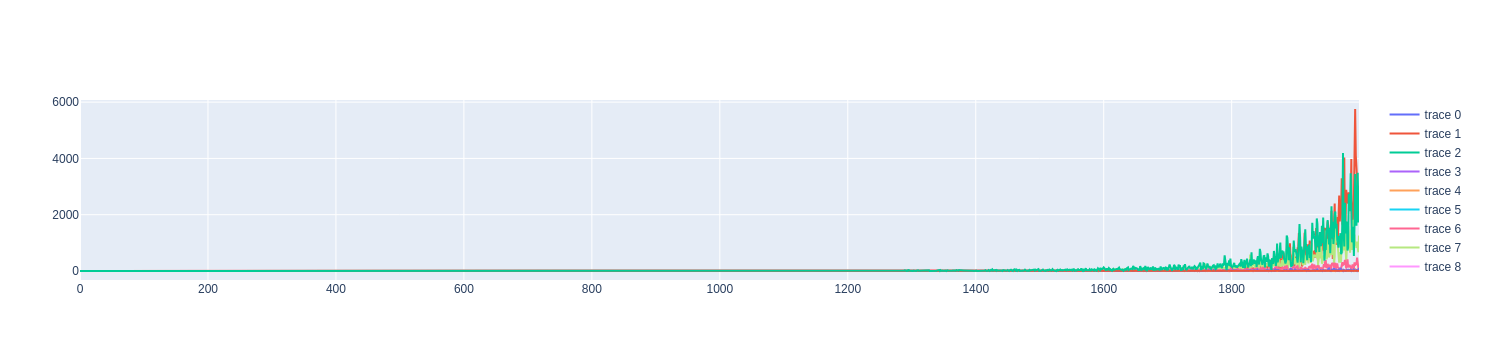

In [171]:
plot_trace(good_trace)

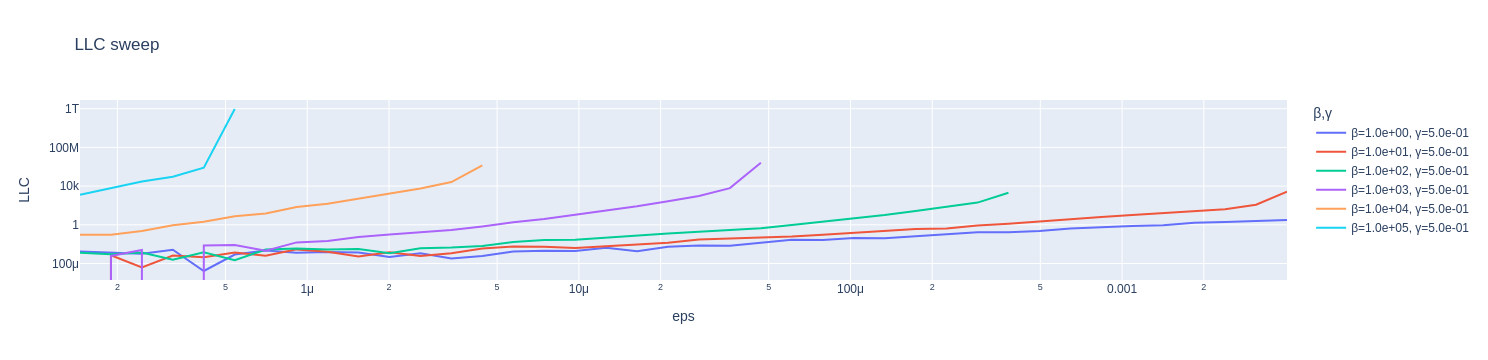

In [143]:
plot_llc_sweep(llc, eps_l, beta_l, gamma_l).show()

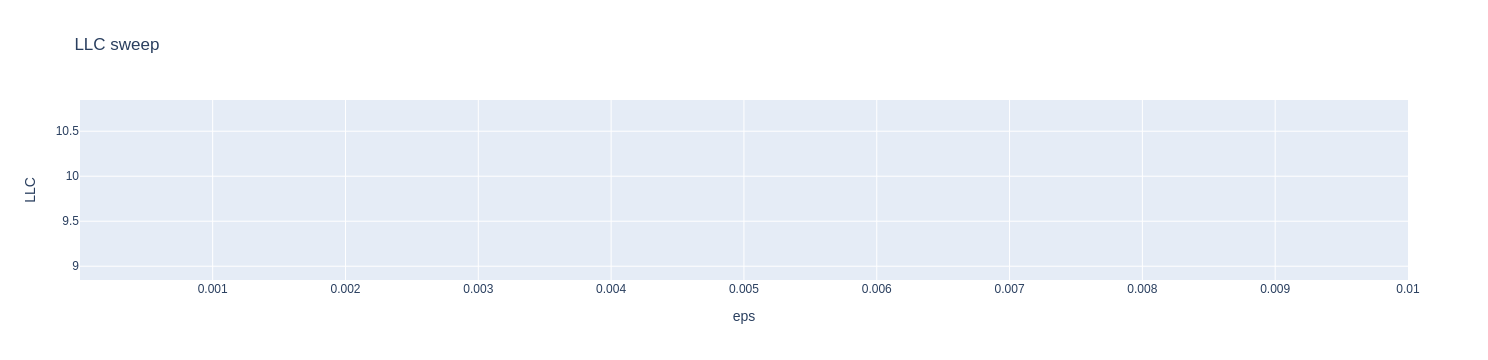

In [90]:
fig = plot_llc_sweep(llc, eps_l, beta_l, gamma_l)
fig.show()

In [62]:
trace = sgld_trace(models[-1], dataset, eps=1e-4, beta=200., gamma=0.5)

SGLD:   0%|          | 0/2000 [00:00<?, ?it/s]

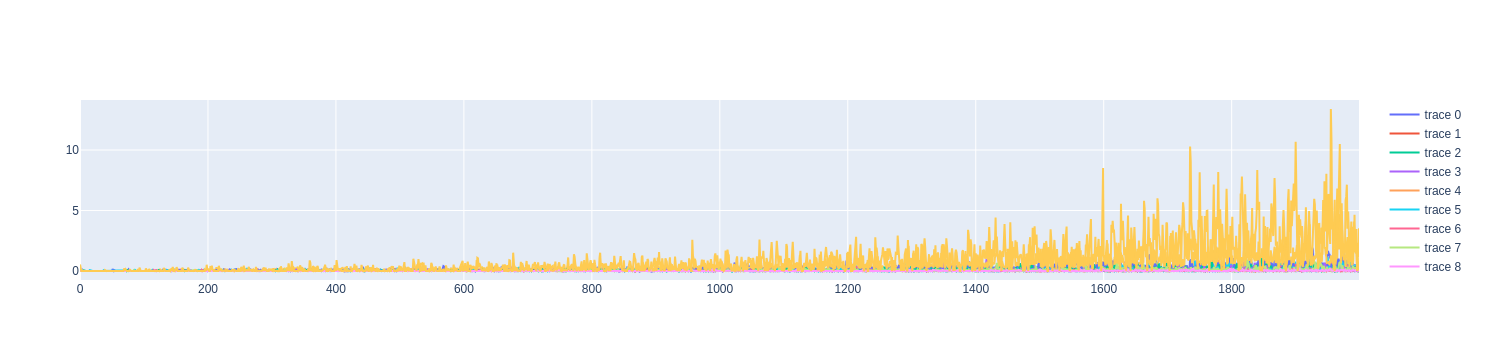

In [70]:
fig = plot_trace(trace)
fig.show()

In [66]:
isinstance(fig, go.Figure)

True

In [47]:
orig_loss = train_loss(models[-1], dataset)

In [52]:
llc_from_trace(trace, orig_loss, beta=100.)

tensor([ 3.0764e-02, -8.7091e+00, -2.0609e+01,  4.7149e-02, -1.0775e+01,
        -8.6797e+00,  1.2063e-02,  4.2773e-03, -2.2527e+00, -8.8957e+00,
         3.3285e-02,  1.4252e-02, -2.8599e+00, -3.1060e+00, -5.9371e+00,
        -3.5923e-01,  1.3874e-02, -1.7605e+00,  2.0867e-02, -5.4259e+01],
       device='cuda:0')

In [30]:
torch.tensor(3).shape

torch.Size([])

In [46]:
a = t.tensor([1, 2, 3, 4])
b = t.ones((4, 3, 5))

In [47]:
b

tensor([[[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]])

In [48]:
einops.einsum(a, b, 'instance, instance ... -> instance ...')

tensor([[[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2.]],

        [[3., 3., 3., 3., 3.],
         [3., 3., 3., 3., 3.],
         [3., 3., 3., 3., 3.]],

        [[4., 4., 4., 4., 4.],
         [4., 4., 4., 4., 4.],
         [4., 4., 4., 4., 4.]]])

In [76]:
del a, b